In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
#warnings
import warnings
warnings.filterwarnings('ignore')

#***Load the Dataset from Kaggle:-***

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
#api kaggle in kaggle cli
!kaggle datasets download rpjinu/forest-fire-dataset

Dataset URL: https://www.kaggle.com/datasets/rpjinu/forest-fire-dataset
License(s): MIT
100% 6.42G/6.42G [05:37<00:00, 23.1MB/s]
100% 6.42G/6.42G [05:37<00:00, 20.4MB/s]


#***Unzip the file:-***

In [4]:
#unzip the file
zip_ref = zipfile.ZipFile('/content/forest-fire-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# Set paths for training and testing data
train = '/content/train'
test = '/content/test'

## ***Data Preprocessing:-***

In [6]:
img_width, img_height = 150, 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 32398 images belonging to 3 classes.
Found 10500 images belonging to 3 classes.


#***Building Model:-***

In [8]:
# Building the Mood Classification Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [9]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 524s 508ms/step - accuracy: 0.8318 - loss: 0.4470 - val_accuracy: 0.8612 - val_loss: 0.4485
Epoch 2/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 512s 502ms/step - accuracy: 0.9155 - loss: 0.2459 - val_accuracy: 0.9053 - val_loss: 0.3142
Epoch 3/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 555s 496ms/step - accuracy: 0.9245 - loss: 0.2172 - val_accuracy: 0.9189 - val_loss: 0.2453
Epoch 4/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 554s 489ms/step - accuracy: 0.9334 - loss: 0.1952 - val_accuracy: 0.9076 - val_loss: 0.3310
Epoch 5/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 547s 537ms/step - accuracy: 0.9371 - loss: 0.1918 - val_accuracy: 0.9392 - val_loss: 0.1909
Epoch 6/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 516s 492ms/step - accuracy: 0.9459 - loss: 0.1713 - val_accuracy: 0.9327 - val_loss: 0.2087
Epoch 7/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 503s 493ms/step - accuracy: 0.9446 - loss: 0.1691 - val_accuracy: 0.9325 - val_loss: 0.2356
Epoch 8/10
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 501s 492ms/step - ac

In [11]:
# Evaluate the model
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

329/329 ━━━━━━━━━━━━━━━━━━━━ 80s 244ms/step - accuracy: 0.9255 - loss: 0.2890
Test Loss: 0.2725003957748413, Test Accuracy: 0.9239047765731812


In [12]:
# Generate Classification Report
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
y_pred = model.predict(test_generator, steps=test_steps_per_epoch)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

329/329 ━━━━━━━━━━━━━━━━━━━━ 79s 236ms/step


In [15]:
print("Classification Report: \n", classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

Classification Report: 
               precision    recall  f1-score   support

       Smoke       0.33      0.32      0.32      3500
        fire       0.33      0.33      0.33      3500
    non fire       0.32      0.33      0.33      3500

    accuracy                           0.33     10500
   macro avg       0.33      0.33      0.33     10500
weighted avg       0.33      0.33      0.33     10500



In [16]:
# Save the model
model.save('Fire_Detection_model.h5')

#Test the Model Work Or NOT:-

In [40]:
# Function to preprocess and predict
def predict_image(image_path):
    image = load_img(image_path, target_size=(img_width, img_height))

    # Convert the image to a NumPy array
    image_array = img_to_array(image)

    # Normalize the pixel values to [0, 1]
    image_array = image_array / 255.0

    # Add batch dimension (1, img_width, img_height, 3)
    image_array = np.expand_dims(image_array, axis=0)

    # Predict the class probabilities
    predictions = model.predict(image_array)

    # Get the class index with the highest probability
    predicted_class_index = np.argmax(predictions)

    # Map class index to label
    class_labels = {1: "Fire", 0: "Smoke", 2: "Non-Fire"}  # Update this mapping based on your dataset
    predicted_label = class_labels[predicted_class_index]
    return predicted_label

In [31]:
#load images to test model
test_image="/content/0LX5QCK3F6AD.jpg"

In [34]:
test_image2="/content/Fire (17).png"

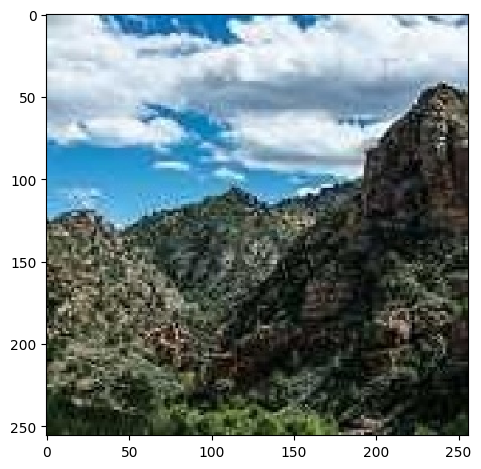

In [32]:
from skimage.io import imshow

# Display the image
imshow(test_image)

In [41]:
# Test the function
predicted_label = predict_image(test_image)

print(f"The image is classified as: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The image is classified as: Non-Fire


***As per image the fire detection model working good i think lets check on fire image below***

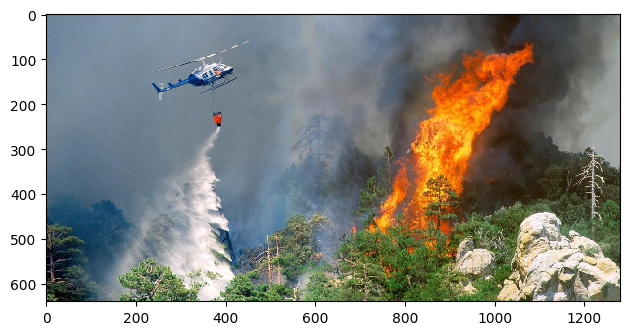

In [37]:
# Display the image
imshow(test_image2)

In [36]:
# Test the function
predicted_label = predict_image(test_image2)

print(f"The image is classified as: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
The image is classified as: Fire


***model working perfectly alright it detect the fire from image***